In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

#Select GPU if can
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPU, 1 Logical GPU


2024-04-05 13:42:18.002991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-05 13:42:18.003009: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-05 13:42:18.003012: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-05 13:42:18.003037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-05 13:42:18.003051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten train data
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# Reshape data for SVD
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


n_components = 12*12
# Apply SVD for data with 12*12 features(144 total from 784)
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(x_train_flat)
x_test_svd = svd.transform(x_test_flat)

# Reshape data to 3 dims for augmentation method
x_train_svd = x_train_svd.reshape(x_train.shape[0], n_components, 1, 1)
x_test_svd = x_test_svd.reshape(x_test.shape[0], n_components, 1, 1)


In [4]:
# Convert the data to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_svd, y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((x_test_svd, y_test))

# Augment data
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label
train_dataset = train_dataset.map(augment)


In [5]:
#Final model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_components, 1, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
#Fit model
history = model.fit(
    train_dataset.batch(32),
    validation_data=test_dataset.batch(32),
    epochs=100)


Epoch 1/25


2024-04-05 13:42:28.298747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.4517 - accuracy: 0.8703 - val_loss: 0.3118 - val_accuracy: 0.9107
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3366 - accuracy: 0.9067 - val_loss: 0.3174 - val_accuracy: 0.9098
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3358 - accuracy: 0.9073 - val_loss: 0.3341 - val_accuracy: 0.9057
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3379 - accuracy: 0.9066 - val_loss: 0.3436 - val_accuracy: 0.9045
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3419 - accuracy: 0.9061 - val_loss: 0.3491 - val_accuracy: 0.9048
Epoch 6/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3458 - accuracy: 0.9063 - val_loss: 0.3687 - val_accuracy: 0.9003
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3494 - accuracy: 0.9054 - val_loss: 0.3894 - val_accuracy: 0.8988
E

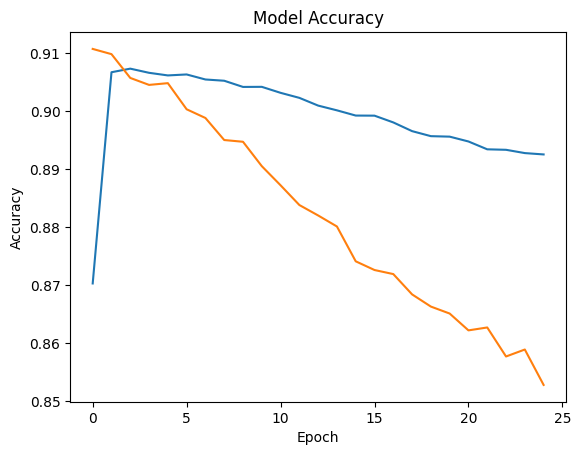

In [7]:
#Plot learnring curve
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    train_color = '#00bfff'  # Deep sky blue
    val_color = '#ff7f50'    # Coral


    axs[0].plot(hist.history['accuracy'], color=train_color)
    axs[0].plot(hist.history['val_accuracy'], color=val_color)
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color=train_color)
    axs[1].plot(hist.history['val_loss'], color=val_color)
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(history)

In [ ]:
model.summary()